In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import itertools
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve 
import numpy as np
import pandas as pd

import string
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
import tqdm

# 1. Preprocessing

In [2]:
# We define utility functions for text processing.

def removePunctuation(text):
    """
    Remove punctuation symbols and convert text to lowercase
    """
    return text.lower().translate(str.maketrans('', '', string.punctuation))

def removeStopWords(text):
    """
    Filter words that are not found in stop words
    """
    return " ".join([word for word in text.split() if word not in stopwords.words("english")])

def buildDictionary(texts):
    """
    Build the dictionary of words where key is the word and value is the index.
    """
    hashmap = {}
    for text in texts:
        for word in text.split():
            hashmap[word] = hashmap.get(word, 0) + 1
    return {w:i+1 for i, w in enumerate(list(hashmap.keys()))}

def calculateMaxSeqLen(texts):
    """
    Calculates the maximum sequence length found in the corpus
    """
    max_len = float('-inf')
    for text in texts:
        if len(text.split()) > max_len:
            max_len = len(text.split())
            
    return max_len

In [3]:
# Load the *.csv* file and filter the features that are useful for the problem:
data = pd.read_csv("C:/datasets/coronavirus/preprocessed_data.csv")

In [4]:
data = pd.concat((data[data["Sentiment"] == 0], data[data["Sentiment"] == 4]), axis=0)

In [5]:
data["Sentiment"] = data["Sentiment"].replace(4, 1)

In [6]:
data["Sentiment"].value_counts()

0    6624
1    5481
Name: Sentiment, dtype: int64

In [7]:
# Text preprocessing. Remove punctuation symbols and stop words:
# data["OriginalTweet"] = data["OriginalTweet"].apply(lambda x: removePunctuation(x))
# data["OriginalTweet"] = data["OriginalTweet"].apply(lambda x: removeStopWords(x))

In [8]:
dictionary = buildDictionary(data["OriginalTweet"])
max_seq_len = calculateMaxSeqLen(data["OriginalTweet"])

print(f"Number of words in dictionary: {len(dictionary)}")
print(f"Maximum sequence lenght: {max_seq_len}")

Number of words in dictionary: 35674
Maximum sequence lenght: 45


In [9]:
data["Sentiment"].value_counts() / len(data)

0    0.547212
1    0.452788
Name: Sentiment, dtype: float64

In [10]:
data

,OriginalTweet,Sentiment
11,due covid19 situation increased demand food pr...,0
12,horningsea caring community letâs look less c...,0
18,amazon glitch stymies whole foods fresh grocer...,0
22,amazing cheap deals covid2019 going help trial...,0
23,amazing cheap deals covid2019 going help trial...,0
...,...,...
41115,food banks equipped 30 unemployment rate feder...,1
41128,covid19 pandemic global oil price wars economi...,1
41130,squeo works meat department kroger supermarket...,1
41133,singaporean politician slammed woman snapped s...,1


In [11]:
# Split data into training and testing
x_train, x_valid, y_train, y_valid = train_test_split(data["OriginalTweet"], data["Sentiment"], test_size=0.3, stratify=data["Sentiment"])

# 2. Data loaders

In [12]:
y_valid.value_counts()

0    1987
1    1645
Name: Sentiment, dtype: int64

In [13]:
y_train.value_counts()

0    4637
1    3836
Name: Sentiment, dtype: int64

In [14]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
DROPOUT = 0.5
INPUT_SIZE = len(dictionary) + 1
EPOCHS = 30

In [15]:
class DataHandler(Dataset):
    """
    Iterator generator for data loader construction
    """
    
    @staticmethod
    def tokenizer(X, max_seq_len, dicitionary):
        """
        Given a sequence of words, tokenize each word with 
        use of `dictionary` and apply padding considering `max_seq_len`
        """
        sequences = []
        for x in X:
            sequence = [0] * max_seq_len
            for idx, word in enumerate(x.split()):
                sequence[idx] = dictionary[word]
            sequences.append(sequence)
            
        return np.array(sequences)
    
    def __init__(self, x, y, max_seq_len, dictionary):
        self.x = self.tokenizer(x, max_seq_len, dictionary)
        self.y = y.to_numpy()
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [16]:
# Initialize iterator objects for the data loader
train = DataHandler(x_train, y_train, max_seq_len, dictionary)
valid = DataHandler(x_valid, y_valid, max_seq_len, dictionary)

In [17]:
# Initialize data loaders
loader_training = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
loader_valid = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
txt1 = iter(loader_valid)

In [19]:
x, y = next(txt1)

In [20]:
dictionary

{'due': 1,
 'covid19': 2,
 'situation': 3,
 'increased': 4,
 'demand': 5,
 'food': 6,
 'products': 7,
 'wait': 8,
 'time': 9,
 'may': 10,
 'longer': 11,
 'online': 12,
 'orders': 13,
 'particularly': 14,
 'beef': 15,
 'share': 16,
 'freezer': 17,
 'packs': 18,
 'thank': 19,
 'patience': 20,
 'horningsea': 21,
 'caring': 22,
 'community': 23,
 'letâ\x92s': 24,
 'look': 25,
 'less': 26,
 'capable': 27,
 'village': 28,
 'ensure': 29,
 'stay': 30,
 'healthy': 31,
 'bringing': 32,
 'shopping': 33,
 'doors': 34,
 'help': 35,
 'self': 36,
 'isolation': 37,
 'symptoms': 38,
 'exposed': 39,
 'somebody': 40,
 'httpstcolsgrxxhjhh': 41,
 'amazon': 42,
 'glitch': 43,
 'stymies': 44,
 'whole': 45,
 'foods': 46,
 'fresh': 47,
 'grocery': 48,
 'deliveries': 49,
 'â\x93as': 50,
 'spread': 51,
 'weâ\x92ve': 52,
 'seen': 53,
 'significant': 54,
 'increase': 55,
 'people': 56,
 'groceriesâ\x94': 57,
 'spokeswoman': 58,
 'said': 59,
 'statement': 60,
 'â\x93today': 61,
 'resulted': 62,
 'systems': 63,
 'im

In [21]:
x_valid.reset_index()["OriginalTweet"].loc[0].split() 

['coronavirus',
 'got',
 'old',
 'ladies',
 'grocery',
 'store',
 'elbowing',
 'whatâ\x92s',
 'instead',
 'hug',
 'hand',
 'shake',
 'say',
 'hi',
 'funny',
 'thing',
 'still',
 'touching',
 'person',
 'lol']

In [22]:
for word in x_valid.reset_index()["OriginalTweet"].loc[0].split() :
    print(dictionary[word])

112
3081
2921
2648
48
119
4603
1734
410
2987
233
4604
173
2496
2372
1020
206
2933
439
826


In [23]:
x[0]

tensor([ 112, 3081, 2921, 2648,   48,  119, 4603, 1734,  410, 2987,  233, 4604,
         173, 2496, 2372, 1020,  206, 2933,  439,  826,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       dtype=torch.int32)

In [24]:
y_valid.reset_index()["Sentiment"].loc[0]

0

In [25]:
y[0].item()

0

# 3. Model

In [26]:
x.shape, len(y)

(torch.Size([64, 45]), 64)

In [27]:
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
LSTM_LAYERS = 2

class TextClassifier(nn.ModuleList):
    """
    LSTM Network definition
    """
    def __init__(self):
        super(TextClassifier, self).__init__()

        self.batch_size = BATCH_SIZE
        self.embedding_dim = EMBEDDING_DIM
        self.hidden_dim = HIDDEN_DIM
        self.LSTM_layers = LSTM_LAYERS
        self.input_size = INPUT_SIZE

        self.dropout = nn.Dropout(DROPOUT)
        self.embedding = nn.Embedding(num_embeddings=self.input_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_dim, 
                            num_layers=self.LSTM_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(in_features=self.hidden_dim*4, out_features=512)
        self.fc2 = nn.Linear(512, 1)
    

    def forward(self, x):        
        embedded = self.embedding(x)
        out, (hidden, cell) = self.lstm(embedded)
        out = self.dropout(out)
        concat_hidden = torch.cat((hidden[0], hidden[1]), dim=1)
        concat_cell = torch.cat((cell[0], cell[1]), dim=1)
        all_states = torch.cat((concat_hidden, concat_cell), dim=1)
        out = torch.relu_(self.fc1(all_states))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

# Identify device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model initialization
model = TextClassifier().to(device)
print(model)

TextClassifier(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(35675, 256, padding_idx=0)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


In [28]:
x.shape

torch.Size([64, 45])

In [29]:
y.shape

torch.Size([64])

In [30]:
model(x.cuda()).shape

torch.Size([64])

In [31]:
# Optimizer initialization
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

In [32]:
def calculate_accuracy_with_selected_threshold(grand_truth, predictions):
    """
    Accuracy calcuation: (tp + tn) / N
    """
    true_positives, true_negatives = 0, 0
    fpr, tpr, thr = roc_curve(grand_truth, predictions)
    roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thr':thr});
    roc['random'] = roc['fpr'].copy()
    roc['diff'] = roc['tpr'] - roc['fpr']
    roc = roc.sort_values('diff', ascending=False).reset_index().drop('index', axis=1)
    
    for true, pred in zip(grand_truth, predictions):
        if (pred > roc.loc[0,'thr']) and (true == 1):
            true_positives += 1
        elif (pred < roc.loc[0,'thr']) and (true == 0):
            true_negatives += 1
    return (true_positives+true_negatives) / len(grand_truth)

def calculate_accuray_with_point_five(grand_truth, predictions):
    """
    Accuracy calcuation: (tp + tn) / N
    """
    true_positives, true_negatives = 0, 0    
    for true, pred in zip(grand_truth, predictions):
        if (pred > 0.5) and (true == 1):
            true_positives += 1
        elif (pred < 0.5) and (true == 0):
            true_negatives += 1
    return (true_positives+true_negatives) / len(grand_truth)

In [33]:
# Training
EPOCHS = 50
valid_accuracy_min = 0
for epoch in range(EPOCHS):
    model.train()
    train_predictions = []
    for x_batch, y_batch in tqdm.tqdm(loader_training, desc=f"training epoch {epoch+1}"):
        
        x = x_batch.type(torch.LongTensor).to(device)
        y = y_batch.type(torch.FloatTensor).to(device)
        
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Save predictions for metrics calculation
        train_predictions += list(y_pred.squeeze().cpu().detach().numpy())
    
    # Evaluation
    with torch.no_grad():
        model.eval()
        valid_predictions = []
        for x_batch, y_batch in tqdm.tqdm(loader_valid, desc=f"validation epoch {epoch+1}"):
            x = x_batch.type(torch.LongTensor).to(device)
            y = y_batch.type(torch.FloatTensor).to(device)
            
            y_pred = model(x)
            # Save predictions for metrics calculation
            valid_predictions += list(y_pred.squeeze().cpu().detach().numpy())

    train_accuracy = calculate_accuracy_with_selected_threshold(y_train, train_predictions)
    valid_accuracy = calculate_accuracy_with_selected_threshold(y_valid, valid_predictions)
    print(f"epoch: {epoch+1}, loss: {loss.item():.5f}, train: {train_accuracy:.5f}, valid: {valid_accuracy:.5f}")
    if valid_accuracy >= valid_accuracy_min:
        print('Valid metrics improved ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_accuracy_min,valid_accuracy))
        # change the name, for saving multiple files
        torch.save(model.state_dict(), 'text_clf.pt')
        valid_accuracy_min = valid_accuracy
        print("=========================================")

validation epoch 1: 100%|██████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.66it/s]


epoch: 1, loss: 0.34329, train: 0.74661, valid: 0.84169
Valid metrics improved (0.000000 --> 0.841685).  Saving model ...


validation epoch 2: 100%|██████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.51it/s]


epoch: 2, loss: 0.06079, train: 0.89118, valid: 0.87390
Valid metrics improved (0.841685 --> 0.873899).  Saving model ...


validation epoch 3: 100%|██████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.52it/s]


epoch: 3, loss: 0.15875, train: 0.95704, valid: 0.82930


validation epoch 4: 100%|██████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 34.86it/s]


epoch: 4, loss: 0.00104, train: 0.97250, valid: 0.89069
Valid metrics improved (0.873899 --> 0.890694).  Saving model ...


validation epoch 5: 100%|██████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.53it/s]


epoch: 5, loss: 0.00370, train: 0.98619, valid: 0.88601


validation epoch 6: 100%|██████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.51it/s]


epoch: 6, loss: 0.05569, train: 0.98879, valid: 0.87252


validation epoch 7: 100%|██████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.49it/s]


epoch: 7, loss: 0.00001, train: 0.99611, valid: 0.89758
Valid metrics improved (0.890694 --> 0.897577).  Saving model ...


validation epoch 8: 100%|██████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.52it/s]


epoch: 8, loss: 0.00000, train: 0.99965, valid: 0.90061
Valid metrics improved (0.897577 --> 0.900606).  Saving model ...


validation epoch 9: 100%|██████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.51it/s]


epoch: 9, loss: 0.00000, train: 0.99953, valid: 0.89317


validation epoch 10: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.53it/s]


epoch: 10, loss: 0.00004, train: 0.99764, valid: 0.89097


validation epoch 11: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.55it/s]


epoch: 11, loss: 0.00027, train: 0.99516, valid: 0.89620


validation epoch 12: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.52it/s]


epoch: 12, loss: 0.00001, train: 0.99681, valid: 0.89868


validation epoch 13: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.53it/s]


epoch: 13, loss: 0.00000, train: 0.99870, valid: 0.90336
Valid metrics improved (0.900606 --> 0.903359).  Saving model ...


validation epoch 14: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.54it/s]


epoch: 14, loss: 0.00000, train: 0.99988, valid: 0.90061


validation epoch 15: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.61it/s]


epoch: 15, loss: 0.00000, train: 0.99988, valid: 0.90088


validation epoch 16: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.62it/s]


epoch: 16, loss: 0.00000, train: 0.99988, valid: 0.90088


validation epoch 17: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.59it/s]


epoch: 17, loss: 0.00000, train: 0.99988, valid: 0.90198


validation epoch 18: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.53it/s]


epoch: 18, loss: 0.00000, train: 0.99988, valid: 0.90363
Valid metrics improved (0.903359 --> 0.903634).  Saving model ...


validation epoch 19: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.62it/s]


epoch: 19, loss: 0.00000, train: 0.99988, valid: 0.90391
Valid metrics improved (0.903634 --> 0.903910).  Saving model ...


validation epoch 20: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.51it/s]


epoch: 20, loss: 0.00000, train: 0.99988, valid: 0.90419
Valid metrics improved (0.903910 --> 0.904185).  Saving model ...


validation epoch 21: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.60it/s]


epoch: 21, loss: 0.00000, train: 0.99988, valid: 0.90391


validation epoch 22: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.56it/s]


epoch: 22, loss: 0.00000, train: 0.99988, valid: 0.90419
Valid metrics improved (0.904185 --> 0.904185).  Saving model ...


validation epoch 23: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.56it/s]


epoch: 23, loss: 0.00000, train: 0.99988, valid: 0.90474
Valid metrics improved (0.904185 --> 0.904736).  Saving model ...


validation epoch 24: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.55it/s]


epoch: 24, loss: 0.00000, train: 0.99988, valid: 0.90446


validation epoch 25: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.56it/s]


epoch: 25, loss: 0.00000, train: 0.99988, valid: 0.90474
Valid metrics improved (0.904736 --> 0.904736).  Saving model ...


validation epoch 26: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.56it/s]


epoch: 26, loss: 0.00000, train: 0.99988, valid: 0.90474
Valid metrics improved (0.904736 --> 0.904736).  Saving model ...


validation epoch 27: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.59it/s]


epoch: 27, loss: 0.00000, train: 0.99988, valid: 0.90474
Valid metrics improved (0.904736 --> 0.904736).  Saving model ...


validation epoch 28: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.56it/s]


epoch: 28, loss: 0.00000, train: 0.99988, valid: 0.90556
Valid metrics improved (0.904736 --> 0.905562).  Saving model ...


validation epoch 29: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.57it/s]


epoch: 29, loss: 0.00000, train: 0.99988, valid: 0.90584
Valid metrics improved (0.905562 --> 0.905837).  Saving model ...


validation epoch 30: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.60it/s]


epoch: 30, loss: 0.00000, train: 0.99988, valid: 0.90584
Valid metrics improved (0.905837 --> 0.905837).  Saving model ...


validation epoch 31: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.60it/s]


epoch: 31, loss: 0.00000, train: 0.99988, valid: 0.90584
Valid metrics improved (0.905837 --> 0.905837).  Saving model ...


validation epoch 32: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.59it/s]


epoch: 32, loss: 0.00000, train: 0.99988, valid: 0.90639
Valid metrics improved (0.905837 --> 0.906388).  Saving model ...


validation epoch 33: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.55it/s]


epoch: 33, loss: 0.00000, train: 0.99988, valid: 0.90584


validation epoch 34: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.56it/s]


epoch: 34, loss: 0.00000, train: 0.99988, valid: 0.90556


validation epoch 35: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.61it/s]


epoch: 35, loss: 0.00000, train: 0.99988, valid: 0.90529


validation epoch 36: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.57it/s]


epoch: 36, loss: 0.00000, train: 0.99988, valid: 0.90529


validation epoch 37: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.54it/s]


epoch: 37, loss: 0.00000, train: 0.99988, valid: 0.90611


validation epoch 38: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.51it/s]


epoch: 38, loss: 0.00000, train: 0.99988, valid: 0.90611


validation epoch 39: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.53it/s]


epoch: 39, loss: 0.00000, train: 0.99988, valid: 0.90611


validation epoch 40: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.49it/s]


epoch: 40, loss: 0.00000, train: 0.99988, valid: 0.90529


validation epoch 41: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.54it/s]


epoch: 41, loss: 0.00000, train: 0.99988, valid: 0.90529


validation epoch 42: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.56it/s]


epoch: 42, loss: 0.00000, train: 0.99988, valid: 0.90529


validation epoch 43: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.54it/s]


epoch: 43, loss: 0.00000, train: 0.99988, valid: 0.90611


validation epoch 44: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.53it/s]


epoch: 44, loss: 0.00000, train: 0.99988, valid: 0.90611


validation epoch 45: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.52it/s]


epoch: 45, loss: 0.00000, train: 0.99988, valid: 0.90584


validation epoch 46: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.54it/s]


epoch: 46, loss: 0.00000, train: 0.99988, valid: 0.90584


validation epoch 47: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.57it/s]


epoch: 47, loss: 0.00000, train: 0.99988, valid: 0.90611


validation epoch 48: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.54it/s]


epoch: 48, loss: 0.00000, train: 0.99988, valid: 0.90639
Valid metrics improved (0.906388 --> 0.906388).  Saving model ...


validation epoch 49: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.53it/s]


epoch: 49, loss: 0.00000, train: 0.99988, valid: 0.90639
Valid metrics improved (0.906388 --> 0.906388).  Saving model ...


validation epoch 50: 100%|█████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 35.55it/s]


epoch: 50, loss: 0.00000, train: 0.99988, valid: 0.90639
Valid metrics improved (0.906388 --> 0.906388).  Saving model ...


In [40]:
model.load_state_dict(torch.load('text_clf.pt'))

<All keys matched successfully>

In [41]:
with torch.no_grad():
    model.eval()
    valid_predictions = []
    for x_batch, y_batch in loader_valid:
        x = x_batch.type(torch.LongTensor).to(device)
        y = y_batch.type(torch.FloatTensor).to(device)

        y_pred = model(x)
        # Save predictions for metrics calculation
        valid_predictions += list(y_pred.squeeze().cpu().detach().numpy())
        
    valid_accuracy = calculate_accuracy_with_selected_threshold(y_valid, valid_predictions)
    print(f"valid accuracy: {valid_accuracy:.5f}")

valid accuracy: 0.90639


<AxesSubplot:xlabel='fpr'>

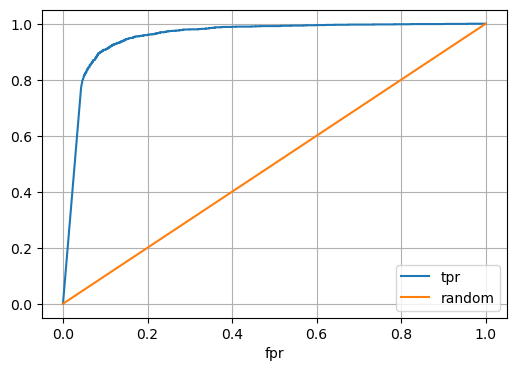

In [42]:
fpr, tpr, thr = roc_curve(y_valid, valid_predictions)
roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thr':thr});
roc['random'] = roc['fpr'].copy()
roc['diff'] = roc['tpr'] - roc['fpr']
roc.plot(x='fpr', y=['tpr','random'], figsize=(6,4), grid=True)

In [43]:
roc = roc.sort_values('diff', ascending=False).reset_index().drop('index', axis=1)

In [44]:
roc

,fpr,tpr,thr,random,diff
0,0.084046,0.895441,8.948165e-01,0.084046,0.811394
1,0.096125,0.906991,3.739784e-01,0.096125,0.810866
2,0.095622,0.906383,4.066698e-01,0.095622,0.810761
3,0.093608,0.903951,5.118250e-01,0.093608,0.810343
4,0.090589,0.900912,7.248901e-01,0.090589,0.810323
...,...,...,...,...,...
372,0.901359,0.998784,2.598422e-19,0.901359,0.097425
373,0.955712,1.000000,2.926914e-21,0.955712,0.044288
374,0.955712,0.999392,3.060857e-21,0.955712,0.043680
375,0.000000,0.000000,2.000000e+00,0.000000,0.000000


In [45]:
roc.loc[0,'thr']

0.89481646